
# 5.1 General
## Names: Nissim Brami (316581271) & Amnon Abaev (322932849)

### About our aproach:
TwoStageOpenMax implementation with class-mean based OOD detection.

This model implements a two-stage approach for open set recognition:
1. A CNN-based feature extractor and classifier for MNIST digits
2. A distance-based detector that identifies unknown samples based on their
   distance from class means in the embedding space

The model achieves high accuracy on both MNIST classification and OOD detection
by establishing a statistical threshold on distances in the embedding space.


In [1]:
# Set run_type parameter: True for testing-only, False for full pipeline
eval_mode = True

In [ ]:
# Imports and utilities
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset, Subset, SubsetRandomSampler
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import warnings
import time
from functools import partial
from matplotlib.colors import LinearSegmentedColormap
tqdm = partial(tqdm, disable=True)
warnings.filterwarnings('ignore')

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model saving path
osr_model_path = "./osr_model.pth"

Using device: cuda



# 5.2 Data & Preprocessing


# Hyperparameters section



In [3]:
'''Model Configuration'''
embed_size = 64
rejection_percentile = 95

'''Training Configuration'''
batch_size = 64
num_epochs = 50
learning_rate = 0.001
weight_decay = 0.001
patience = 2
step_size_factor = 0.5

'''Data Transformation Configuration'''
transform_params = {
    'normalization_mean': 0.1307,
    'normalization_std': 0.3081
}


# Utility Functions


In [4]:
def store_model(model, path):
    """
    Save model state dictionary to the specified path

    Args:
        model (nn.Module): Model to save
        path (str): Path where model will be stored
    """
    torch.save(model.state_dict(), path)

def retrieve_model(model, path):
    """
    Load model state dictionary from the specified path

    Args:
        model (nn.Module): Model instance to load weights into
        path (str): Path to the saved model file

    Returns:
        model: The model with loaded weights, set to evaluation mode
    """
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model


# Data Loading Functions


In [5]:
def prepare_data_loaders():
    """
    Prepare MNIST data loaders for training, validation, and testing

    Returns:
        tuple: (train_loader, val_loader, test_loader, test_set)
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((transform_params['normalization_mean'],), (transform_params['normalization_std'],))
    ])

    train_set = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_set = datasets.MNIST('./data', train=False, download=True, transform=transform)

    train_size = int(0.9 * len(train_set))
    val_size = len(train_set) - train_size
    train_set, val_set = random_split(train_set, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader, test_set


def prepare_outlier_data():
    """
    Prepare FashionMNIST and CIFAR10 as outlier datasets for OOD testing

    Returns:
        tuple: Various loaders and subsets for outlier data
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((transform_params['normalization_mean'],), (transform_params['normalization_std'],))
    ])

    outlier_transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((transform_params['normalization_mean'],), (transform_params['normalization_std'],))
    ])

    # FashionMNIST as OOD
    fashion_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
    indices = torch.randperm(len(fashion_dataset))[:1000]
    fashion_subset = Subset(fashion_dataset, indices)

    # CIFAR10 as additional OOD
    cifar_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=outlier_transform)
    indices = torch.randperm(len(cifar_dataset))[:1000]
    cifar_subset = Subset(cifar_dataset, indices)

    # Combined OOD dataset
    combined_ood = torch.utils.data.ConcatDataset([fashion_subset, cifar_subset])

    # Create DataLoaders
    fashion_loader = DataLoader(fashion_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    cifar_loader = DataLoader(cifar_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    combined_loader = DataLoader(combined_ood, batch_size=batch_size, shuffle=False, num_workers=2)

    return fashion_loader, cifar_loader, combined_loader, fashion_subset, cifar_subset, combined_ood


def sample_outlier_data(dataset, num_samples=2000):
    """
    Sample a subset of data from a dataset

    Args:
        dataset (Dataset): Dataset to sample from
        num_samples (int): Number of samples to take

    Returns:
        Subset: Sampled subset of the dataset
    """
    indices = torch.randperm(len(dataset))[:num_samples]
    return Subset(dataset, indices)


# 5.3 Models


In [6]:
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10

In [7]:
class TwoStageOpenMax(nn.Module):
    """
    Two-stage OSR model with feature extraction, embedding, and classification.
    Uses distance from class means in embedding space to detect unknown samples.

    Args:
        embedding_dim (int): Size of the embedding space
    """
    def __init__(self, embedding_dim=64):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(2),

            nn.Flatten()
        )

        self.embedding = nn.Sequential(
            nn.Linear(64 * 7 * 7, embedding_dim),
            nn.BatchNorm1d(embedding_dim),
            nn.ReLU(),
            nn.Dropout(0.6)
        )

        self.classifier = nn.Linear(embedding_dim, 10)

        # Register buffers for mean vectors
        self.register_buffer('class_means', torch.zeros(10, embedding_dim))
        self.register_buffer('distance_threshold', torch.tensor(5.0))

    def forward(self, x):
        """
        Forward pass through the model

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, channels, height, width]

        Returns:
            tuple: (logits, embeddings) containing classification logits and feature embeddings
        """
        features = self.features(x)
        embeddings = self.embedding(features)
        logits = self.classifier(embeddings)
        return logits, embeddings

    def compute_class_means(self, train_loader, percentile=95):
        """
        Compute mean embeddings for each class and set a threshold for OOD detection.

        This method:
        1. Extracts embeddings for all training samples
        2. Groups them by class and computes the mean embedding for each class
        3. Measures distances from samples to their respective class means
        4. Sets a threshold based on the specified percentile of these distances

        Args:
            train_loader (DataLoader): DataLoader containing training data
            percentile (float): Percentile of distances to use as threshold (default: 95)
                - Higher percentile = more strict rejection (fewer false positives)
                - Lower percentile = more lenient rejection (fewer false negatives)

        Returns:
            None: Updates the model's class_means and distance_threshold buffers in-place

        Notes:
            - The threshold percentile should be tuned based on the expected proportion of OOD data
            - The distance distribution is visualized and saved to 'plots/distance_threshold.png'
        """
        self.eval()
        class_embeddings = {i: [] for i in range(10)}

        with torch.no_grad():
            for data, targets in tqdm(train_loader, desc="Computing class means"):
                data = data.to(device)
                _, embeddings = self(data)

                for i in range(10):
                    mask = targets == i
                    if mask.any():
                        class_embeddings[i].append(embeddings[mask])

        all_distances = []
        for i in range(10):
            if class_embeddings[i]:
                embeddings = torch.cat(class_embeddings[i], dim=0)
                mean = embeddings.mean(0)
                self.class_means[i] = mean

                distances = torch.norm(embeddings - mean.unsqueeze(0), dim=1)
                all_distances.extend(distances.cpu().numpy())

        distances = np.array(all_distances)
        threshold = np.percentile(distances, percentile)
        self.distance_threshold = torch.tensor(threshold).to(device)

        print(f"Computed class means and set threshold to {threshold:.2f}")
        print(f"Distance statistics: min={distances.min():.2f}, "
                   f"mean={distances.mean():.2f}, max={distances.max():.2f}")

        # Create a histogram of distances with threshold marked
        plt.figure(figsize=(10, 6))
        plt.hist(distances, bins=50, alpha=0.7, color='blue')
        plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2)
        plt.title('Distribution of Distances to Class Means', fontsize=14)
        plt.xlabel('Distance', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.text(threshold*1.05, plt.ylim()[1]*0.9, f'Threshold: {threshold:.2f}',
                color='red', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.show()

    def predict_with_detection(self, x):
        """
        Perform classification with OOD detection.

        This method:
        1. Extracts features and embeddings from the input data
        2. Computes standard classification predictions
        3. Measures the distance from each sample to its predicted class mean
        4. Marks samples with distances exceeding the threshold as 'unknown' (class 10)

        Args:
            x (torch.Tensor): Input data tensor of shape [batch_size, 784] or [batch_size, 1, 28, 28]

        Returns:
            tuple:
                - predictions (torch.Tensor): Class predictions (0-9 for known, 10 for unknown)
                - confidences (torch.Tensor): Softmax confidence scores for each prediction
                - distances (torch.Tensor): Distances from samples to their predicted class means

        Notes:
            - Unknown samples (class 10) are those whose distance exceeds the threshold
            - This enables the model to identify OOD samples not seen during training
        """
        self.eval()
        with torch.no_grad():
            logits, embeddings = self(x)
            predictions = logits.argmax(dim=1)
            confidences = F.softmax(logits, dim=1).max(dim=1).values

            distances = []
            for i, pred in enumerate(predictions):
                dist = torch.norm(embeddings[i] - self.class_means[pred])
                distances.append(dist.item())

            distances = torch.tensor(distances).to(device)
            unknown_mask = distances > self.distance_threshold
            predictions[unknown_mask] = 10  # 10 represents unknown

            return predictions, confidences, distances


# 5.4 Training Infrastructure


In [8]:
class ModelProcessor:
    """
    Handles the training and evaluation process for the OSR model.

    Args:
        model (nn.Module): Model to train
        train_loader (DataLoader): DataLoader for training data
        val_loader (DataLoader): DataLoader for validation data
    """
    def __init__(self, model, train_loader, val_loader):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.criterion = nn.CrossEntropyLoss()
        # Added weight decay for L2 regularization
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=step_size_factor, patience=patience, verbose=True
        )

        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []

    def train_epoch(self, epoch):
        """
        Train the model for one epoch

        Args:
            epoch (int): Current epoch number

        Returns:
            tuple: (epoch_loss, epoch_accuracy) for the training set
        """
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch}')
        for batch_idx, (data, targets) in enumerate(pbar):
            data, targets = data.to(device), targets.to(device)

            self.optimizer.zero_grad()
            logits, embeddings = self.model(data)

            # Added L2 regularization on embeddings
            l2_lambda = 0.001
            l2_reg = torch.norm(embeddings, p=2, dim=1).mean()

            loss = self.criterion(logits, targets) + l2_lambda * l2_reg

            loss.backward()

            # Added gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            pbar.set_postfix({
                'loss': running_loss/(batch_idx+1),
                'acc': 100.*correct/total
            })

        epoch_loss = running_loss/len(self.train_loader)
        epoch_acc = 100.*correct/total
        self.train_losses.append(epoch_loss)
        self.train_accs.append(epoch_acc)
        return epoch_loss, epoch_acc

    def validate(self):
        """
        Validate the model on the validation set

        Returns:
            tuple: (avg_loss, avg_accuracy) for the validation set
        """
        self.model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in self.val_loader:
                data, targets = data.to(device), targets.to(device)
                logits, _ = self.model(data)
                loss = self.criterion(logits, targets)

                val_loss += loss.item()
                _, predicted = logits.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        avg_loss = val_loss/len(self.val_loader)
        avg_acc = 100.*correct/total
        self.val_losses.append(avg_loss)
        self.val_accs.append(avg_acc)

        self.scheduler.step(avg_loss)
        return avg_loss, avg_acc

    def plot_training_history(self):
        """
        Plot and save training metrics (loss and accuracy curves)
        """
        plt.figure(figsize=(15, 5))

        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss', color='blue', marker='o', markersize=3)
        plt.plot(self.val_losses, label='Val Loss', color='red', marker='o', markersize=3)
        plt.title('Loss During Training', fontsize=14)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)

        # Plot accuracies
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accs, label='Train Acc', color='blue', marker='o', markersize=3)
        plt.plot(self.val_accs, label='Val Acc', color='red', marker='o', markersize=3)
        plt.title('Accuracy During Training', fontsize=14)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Accuracy (%)', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def train(self, num_epochs=50):
        """
        Train the model for the specified number of epochs

        Args:
            num_epochs (int): Number of epochs to train for

        Returns:
            float: Best validation accuracy achieved
        """
        best_val_acc = 0

        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate()


            if val_acc > best_val_acc:
                best_val_acc = val_acc
                store_model(self.model, osr_model_path)

        # Plot training history
        self.plot_training_history()

        # Compute class means for unknown detection
        self.model.compute_class_means(self.train_loader, percentile=rejection_percentile)

        return best_val_acc


### Data & Predictions Visualisation Functions

In [ ]:
def visualize_data_examples(mnist_data, ood_data, num_samples=5):
    """
    Visualize examples of MNIST and OOD data

    Args:
        mnist_data (Dataset): MNIST dataset
        ood_data (Dataset): OOD dataset
        num_samples (int): Number of samples to display
    """
    # Get samples
    mnist_loader = DataLoader(mnist_data, batch_size=num_samples, shuffle=True)
    ood_loader = DataLoader(ood_data, batch_size=num_samples, shuffle=True)

    mnist_images, mnist_labels = next(iter(mnist_loader))
    ood_images, _ = next(iter(ood_loader))

    # Create figure
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*2, 4))

    # Add main title
    fig.suptitle('Comparison of MNIST and Out-of-Distribution Samples', fontsize=16, fontweight='bold')

    # Plot MNIST samples
    for i in range(num_samples):
        axes[0, i].imshow(mnist_images[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f'MNIST: {mnist_labels[i].item()}')
        axes[0, i].axis('off')

    # Plot OOD samples
    for i in range(num_samples):
        axes[1, i].imshow(ood_images[i].squeeze(), cmap='gray')
        axes[1, i].set_title('OOD Sample')
        axes[1, i].axis('off')

    # Add row labels
    fig.text(0.05, 0.75, 'In-Distribution', fontsize=12, fontweight='bold', ha='center', va='center', rotation=90)
    fig.text(0.05, 0.25, 'Out-of-Distribution', fontsize=12, fontweight='bold', ha='center', va='center', rotation=90)

    plt.tight_layout()
    # Adjust layout to make room for the title
    plt.subplots_adjust(top=0.85, left=0.1)
    plt.show()
    plt.close()

def visualize_model_predictions(model, test_loader, ood_loader, num_samples=8):
    """
    Visualize model predictions on both test and OOD data in a comprehensive layout.
    Combines features from visualize_sample_predictions and compare_individual_samples.

    Args:
        model (TwoStageOpenMax): Trained model
        test_loader (DataLoader): DataLoader for test data
        ood_loader (DataLoader): DataLoader for OOD data
        num_samples (int): Number of samples to display from each dataset
    """
    model.eval()

    # Get test samples
    test_batch, test_labels = next(iter(test_loader))
    test_batch = test_batch[:num_samples].to(device)
    test_labels = test_labels[:num_samples]

    # Get OOD samples
    ood_batch, _ = next(iter(ood_loader))
    ood_batch = ood_batch[:num_samples].to(device)
    ood_labels = torch.full((num_samples,), 10)  # All OOD samples have label 10

    # Get predictions
    with torch.no_grad():
        test_preds, test_confs, test_dists = model.predict_with_detection(test_batch)
        ood_preds, ood_confs, ood_dists = model.predict_with_detection(ood_batch)

    # Create figure with 2 rows (MNIST, OOD) and num_samples columns
    # Increase figure height and vertical spacing between rows
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*2, 6), gridspec_kw={'hspace': 1.0})

    # Add main title to the figure with added space
    fig.suptitle('Model Predictions: MNIST vs Out-of-Distribution Samples',
                 fontsize=16, fontweight='bold', y=0.95)

    # Plot test samples (MNIST)
    for i in range(num_samples):
        img = test_batch[i].cpu().squeeze().numpy()
        pred = test_preds[i].item()
        conf = test_confs[i].item()
        dist = test_dists[i].item()
        true_label = test_labels[i].item()

        # Display the image
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].axis('off')

        # Determine if prediction is correct
        if pred == true_label:
            color = 'green'
            result = 'Correct'
        else:
            color = 'red'
            result = 'Incorrect'

        # Format prediction label
        pred_label = 'Unknown' if pred == 10 else str(pred)

        # Display prediction information with smaller font
        axes[0, i].set_title(
            f"True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}\nDist: {dist:.2f}\n{result}",
            color=color, fontsize=8, pad=10
        )

    # Plot OOD samples
    for i in range(num_samples):
        img = ood_batch[i].cpu().squeeze().numpy()
        pred = ood_preds[i].item()
        conf = ood_confs[i].item()
        dist = ood_dists[i].item()

        # Display the image
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].axis('off')

        # Determine if prediction is correct (Unknown for OOD)
        if pred == 10:  # Correctly predicted as unknown
            color = 'green'
            result = 'Correct'
        else:
            color = 'red'
            result = 'Incorrect'

        # Format prediction label
        pred_label = 'Unknown' if pred == 10 else str(pred)

        # Display prediction information with smaller font
        axes[1, i].set_title(
            f"True: Unknown\nPred: {pred_label}\nConf: {conf:.2f}\nDist: {dist:.2f}\n{result}",
            color=color, fontsize=8, pad=10
        )

    # Add row labels
    fig.text(0.05, 0.75, 'MNIST Samples', fontsize=12, fontweight='bold', ha='center', va='center', rotation=90)
    fig.text(0.05, 0.25, 'OOD Samples', fontsize=12, fontweight='bold', ha='center', va='center', rotation=90)

    plt.tight_layout()
    # Adjust layout with more space at top
    plt.subplots_adjust(top=0.78, left=0.1)
    plt.show()


# 5.5 Evaluation Functions

We extended the original `eval_model` function (that was in `project_utils.py`) to create our comprehensive `evaluate_model_performance` function. The key differences and additions include:

### Core Functionality Preserved
- We maintained the original accuracy calculations for MNIST, OOD, and combined datasets
- Results from our function match what `eval_model` would produce

### Key Extensions
1. **Multi-dataset support**: Can evaluate on multiple OOD datasets separately
2. **Additional metrics**: Collects confidence scores and distances to class means
3. **Visualization capabilities**: 
   - Confidence and distance distributions
   - Confusion matrices (both binary and multi-class)
   - t-SNE visualization of the embedding space 
   - ROC curves for OOD detection

### Implementation Details
- Our function has compatible input/output interfaces with original `eval_model`
- Added support for combined datasets through the CombinedDataset class
- Includes comprehensive error handling for visualizations

In [ ]:
def evaluate_model_performance(model, test_loader, ood_loaders, dataset_names=['MNIST', 'FashionMNIST', 'CIFAR10', 'Combined OOD']):
    """
    Comprehensive evaluation of the model on both standard and OOD data.
    Includes functionality from project_utils.py's eval_model function.

    This function:
    1. Evaluates classification accuracy on MNIST test data
    2. Evaluates OOD detection accuracy on provided OOD datasets
    3. Creates visualizations of confidence and distance distributions
    4. Generates confusion matrices and t-SNE visualizations
    5. Computes and displays ROC curves for OOD detection

    Args:
        model (TwoStageOpenMax): The trained model to evaluate
        test_loader (DataLoader): DataLoader for MNIST test data and OOD if exist
        ood_loaders (list): List of DataLoaders for OOD datasets
        dataset_names (list): Names of datasets corresponding to the loaders

    Returns:
        dict: Dictionary containing detailed results for each dataset
    """
    model.eval()
    all_embeddings = []
    all_labels = []
    all_predictions = []
    results = {name: {'correct': 0, 'total': 0, 'confidences': [], 'distances': [], 'embeddings': []}
              for name in dataset_names}

    # Variables to track eval_model style metrics
    combined_loader = None
    combined_results = None

    # Check if this is a combined dataset (containing both MNIST and OOD)
    if len(ood_loaders) == 0 and len(dataset_names) == 1 and isinstance(test_loader.dataset, CombinedDataset):
        # This is a combined dataset evaluation (as expected by eval_model)
        combined_loader = test_loader
        combined_results = {'acc_mnist': 0, 'acc_ood': 0, 'acc_total': 0,
                           'correct_mnist': 0, 'total_mnist': 0,
                           'correct_ood': 0, 'total_ood': 0}

    def process_batch(data, targets, dataset_name, is_known=True):
        with torch.no_grad():
            data = data.to(device)
            predictions, confidences, distances = model.predict_with_detection(data)

            if is_known:
                correct = (predictions == targets.to(device)).sum().item()
            else:
                correct = (predictions == 10).sum().item()

            results[dataset_name]['correct'] += correct
            results[dataset_name]['total'] += len(data)
            results[dataset_name]['confidences'].extend(confidences.detach().cpu().numpy())
            results[dataset_name]['distances'].extend(distances.detach().cpu().numpy())

            # Collect embeddings for visualization
            _, embeddings = model(data)
            all_embeddings.append(embeddings.detach().cpu().numpy())
            results[dataset_name]['embeddings'].append(embeddings.detach().cpu().numpy())
            all_labels.extend([10 if not is_known else t.item() for t in targets])
            all_predictions.extend(predictions.detach().cpu().numpy())

            # If this is a combined dataset, track eval_model style metrics
            if combined_loader is not None:
                # Split into MNIST (known) and OOD (unknown) based on labels
                targets_device = targets.to(device)
                mask_mnist = targets_device < 10
                mask_ood = ~mask_mnist

                # Count correct predictions for each category
                if torch.any(mask_mnist):
                    labels_mnist = targets_device[mask_mnist]
                    pred_mnist = predictions[mask_mnist]
                    combined_results['correct_mnist'] += (pred_mnist == labels_mnist).sum().item()
                    combined_results['total_mnist'] += len(labels_mnist)

                if torch.any(mask_ood):
                    labels_ood = targets_device[mask_ood]
                    pred_ood = predictions[mask_ood]
                    combined_results['correct_ood'] += (pred_ood == 10).sum().item()  # OOD correctly identified as unknown
                    combined_results['total_ood'] += len(labels_ood)

    # Process MNIST test data
    for data, targets in tqdm(test_loader):
        process_batch(data, targets, 'MNIST', True)

    # Process combined OOD dataset if provided
    if len(ood_loaders) > 0:
        for data, targets in tqdm(ood_loaders[-1]):
            process_batch(data, targets, dataset_names[-1], False)

    # Process combined dataset if that's what we're evaluating
    if combined_loader is not None and combined_loader != test_loader:
        for data, targets in tqdm(combined_loader):
            process_batch(data, targets, dataset_names[0], False)  # is_known doesn't matter here

        # Calculate accuracy ratios as in eval_model
        combined_results['acc_mnist'] = combined_results['correct_mnist'] / combined_results['total_mnist'] if combined_results['total_mnist'] > 0 else 0
        combined_results['acc_ood'] = combined_results['correct_ood'] / combined_results['total_ood'] if combined_results['total_ood'] > 0 else 0
        combined_results['acc_total'] = (combined_results['correct_mnist'] + combined_results['correct_ood']) / (combined_results['total_mnist'] + combined_results['total_ood']) if (combined_results['total_mnist'] + combined_results['total_ood']) > 0 else 0

        # Print eval_model style results
        if combined_results['total_ood'] > 0:
            print("\nResults from eval_model style evaluation:")
            print(f"MNIST Accuracy: {combined_results['acc_mnist']*100:.2f}%")
            print(f"OOD Accuracy: {combined_results['acc_ood']*100:.2f}%")
            print(f"Total Accuracy: {combined_results['acc_total']*100:.2f}%")

    # Force computation of eval_model style metrics if not already done
    if combined_results is None:
        combined_results = {
            'acc_mnist': results['MNIST']['correct'] / results['MNIST']['total'] if results['MNIST']['total'] > 0 else 0,
            'acc_ood': 0,
            'acc_total': 0
        }

        # Compute OOD accuracy
        ood_datasets = [d for d in results.keys() if d != 'MNIST' and results[d]['total'] > 0]
        if ood_datasets:
            ood_total = sum(results[d]['total'] for d in ood_datasets)
            ood_correct = sum(results[d]['correct'] for d in ood_datasets)
            combined_results['acc_ood'] = ood_correct / ood_total if ood_total > 0 else 0

        # Compute total accuracy
        total_samples = results['MNIST']['total'] + sum(results[d]['total'] for d in ood_datasets)
        total_correct = results['MNIST']['correct'] + sum(results[d]['correct'] for d in ood_datasets)
        combined_results['acc_total'] = total_correct / total_samples if total_samples > 0 else 0

        # Print eval_model style results only if OOD data exists
        if combined_results['acc_ood'] > 0:
            print("\nResults from eval_model style evaluation:")
            print(f"MNIST Accuracy: {combined_results['acc_mnist']*100:.2f}%")
            print(f"OOD Accuracy: {combined_results['acc_ood']*100:.2f}%")
            print(f"Total Accuracy: {combined_results['acc_total']*100:.2f}%")

    # Print detailed results
    print("\nDetailed Results:")
    print("-" * 50)
    for name in dataset_names:
        if results[name]['total'] > 0:  # Only process if we have data for this dataset
            acc = 100. * results[name]['correct'] / results[name]['total']
            avg_conf = np.mean(results[name]['confidences']) * 100
            avg_dist = np.mean(results[name]['distances'])
            print(f"\n{name} Results:")
            print(f"Accuracy: {acc:.2f}%")
            print(f"Average Confidence: {avg_conf:.2f}%")
            print(f"Average Distance: {avg_dist:.2f}")

    # Create and save visualizations
    try:
       # Prepare data
       all_embeddings = np.concatenate(all_embeddings)
       all_labels = np.array(all_labels)
       all_predictions = np.array(all_predictions)

       # Plot distributions
       fig = plt.figure(figsize=(15, 5))
       fig.suptitle('Confidence and Distance Distributions Across Datasets',
                    fontsize=16, fontweight='bold')

       plt.subplot(1, 2, 1)
       for name in dataset_names:
           if results[name]['total'] > 0:  # Only plot if we have data
               sns.kdeplot(data=results[name]['confidences'], label=name)
       plt.title('Confidence Score Distributions', fontsize=14)
       plt.xlabel('Confidence', fontsize=12)
       plt.ylabel('Density', fontsize=12)
       plt.legend(fontsize=10)
       plt.grid(True, alpha=0.3)

       plt.subplot(1, 2, 2)
       for name in dataset_names:
           if results[name]['total'] > 0:  # Only plot if we have data
               sns.kdeplot(data=results[name]['distances'], label=name)

       # Add threshold line
       threshold = model.distance_threshold.cpu().numpy()
       plt.axvline(threshold, color='red', linestyle='--', linewidth=2)
       plt.text(threshold*1.05, plt.ylim()[1]*0.9, f'Threshold: {threshold:.2f}',
               color='red', fontsize=10)

       plt.title('Distance to Class Mean Distributions', fontsize=14)
       plt.xlabel('Distance', fontsize=12)
       plt.ylabel('Density', fontsize=12)
       plt.legend(fontsize=10)
       plt.grid(True, alpha=0.3)

       plt.tight_layout()
       plt.subplots_adjust(top=0.85)
       plt.show()

       # Confusion matrices
       fig = plt.figure(figsize=(15, 12))
       fig.suptitle('Confusion Matrices for Model Evaluation',
                    fontsize=16, fontweight='bold')

       # Binary confusion matrix (Known vs Unknown)
       binary_labels = (all_labels == 10).astype(int)
       binary_preds = (all_predictions == 10).astype(int)
       binary_cm = confusion_matrix(binary_labels, binary_preds)

       plt.subplot(2, 1, 1)
       sns.heatmap(binary_cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Known', 'Unknown'],
                   yticklabels=['Known', 'Unknown'])
       plt.title('Binary Confusion Matrix (Known vs Unknown)', fontsize=14)
       plt.xlabel('Predicted', fontsize=12)
       plt.ylabel('True', fontsize=12)

       # Full confusion matrix (all classes)
       full_cm = confusion_matrix(all_labels, all_predictions)
       plt.subplot(2, 1, 2)

       # Use class labels for better readability
       class_labels = [str(i) for i in range(10)] + ['Unknown']

       sns.heatmap(full_cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_labels,
                   yticklabels=class_labels)
       plt.title('Full Confusion Matrix (11 classes)', fontsize=14)
       plt.xlabel('Predicted', fontsize=12)
       plt.ylabel('True', fontsize=12)

       plt.tight_layout()
       plt.subplots_adjust(top=0.9)
       plt.show()

       # Extract class means
       class_means = model.class_means.cpu().numpy()

       # Combine embeddings with class means for t-SNE
       combined_data_for_tsne = np.vstack([all_embeddings, class_means])

       # Create labels for class means (11 to 20 to distinguish from data points)
       class_mean_labels = np.array([11 + i for i in range(10)])
       combined_labels_for_tsne = np.concatenate([all_labels, class_mean_labels])

       # Perform t-SNE dimensionality reduction
       tsne = TSNE(n_components=2, random_state=42, perplexity=40, learning_rate=200)
       embeddings_2d = tsne.fit_transform(combined_data_for_tsne)

       # Split back into data points and class means
       data_embeddings_2d = embeddings_2d[:-10]
       class_means_2d = embeddings_2d[-10:]

       # Create a visually appealing t-SNE plot with improved visualization
       fig = plt.figure(figsize=(14, 10))
       plt.suptitle('Embedding Space Visualization with t-SNE',
                    fontsize=16, fontweight='bold')

       # Create a custom colormap with bright, distinct colors for the classes
       distinct_colors = [
           '#FF3333', '#33CC33', '#FFCC00', '#3366FF', '#FF9900',
           '#9933CC', '#00CCFF', '#FF66FF', '#99FF33', '#FF99CC',
           '#000000'  # Black for Unknown
       ]

       # Set figure with proper grid and background
       plt.grid(True, linestyle='--', alpha=0.6)
       plt.gca().set_facecolor('#f8f8f8')

       # First plot all data points with high contrast and clear separation
       for i in range(11):  # 0-9 digits + Unknown (10)
           mask = all_labels == i
           if np.any(mask):
               label = 'Unknown' if i == 10 else f'Class {i}'
               plt.scatter(data_embeddings_2d[mask, 0], data_embeddings_2d[mask, 1],
                         color=distinct_colors[i], label=label, alpha=0.7,
                         edgecolors='none', s=50)

       # Add a single star to the legend to represent all means
       plt.scatter([], [], marker='*', color='gray', edgecolors='black',
                  s=300, linewidth=1.5, label='Class Means')

       # Then plot actual class means as stars
       for i in range(10):  # Only 0-9 have means
           plt.scatter(class_means_2d[i, 0], class_means_2d[i, 1],
                      marker='*', color=distinct_colors[i],
                      edgecolors='black', s=300, linewidth=1.5,
                      label=None)  # No label so it doesn't add to legend

       plt.title('t-SNE Visualization of Embeddings with Class Means', fontsize=16)
       plt.xlabel('t-SNE Dimension 1', fontsize=14)
       plt.ylabel('t-SNE Dimension 2', fontsize=14)

       # Create a cleaner legend with better placement
       plt.legend(fontsize=10, loc='upper right', framealpha=0.9, edgecolor='gray')

       plt.tight_layout()
       plt.subplots_adjust(top=0.9)
       plt.show()

       # Check if we have only MNIST or also OOD data
       has_ood_data = False
       for name in dataset_names:
           if name != 'MNIST' and results[name]['total'] > 0:
               has_ood_data = True
               break

       # Draw the ROC curve only if we also have OOD samples
       if has_ood_data:
           # ROC curve for binary classification (Known vs Unknown)
           fig = plt.figure(figsize=(10, 8))
           plt.suptitle('Receiver Operating Characteristic for Unknown Detection',
                       fontsize=16, fontweight='bold')

           # Calculate FPR, TPR for different thresholds
           unknown_scores = np.array(all_labels == 10, dtype=int)

           # Use distances as scores
           distances_flat = np.concatenate([results[name]['distances'] for name in dataset_names if results[name]['total'] > 0])

           # Calculate ROC curve
           fpr, tpr, thresholds = roc_curve(unknown_scores, distances_flat)
           roc_auc = auc(fpr, tpr)

           # Plot ROC curve
           plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
           plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

           # Mark the current threshold
           current_threshold = model.distance_threshold.cpu().numpy()
           idx = np.argmin(np.abs(thresholds - current_threshold))
           plt.scatter(fpr[idx], tpr[idx], color='red', s=100, label=f'Current threshold ({current_threshold:.2f})')

           plt.xlim([0.0, 1.0])
           plt.ylim([0.0, 1.05])
           plt.xlabel('False Positive Rate', fontsize=12)
           plt.ylabel('True Positive Rate', fontsize=12)
           plt.title('ROC Curve for Unknown Detection', fontsize=14)
           plt.legend(loc="lower right", fontsize=10)
           plt.grid(True, alpha=0.3)

           plt.tight_layout()
           plt.subplots_adjust(top=0.9)
           plt.show()
       else:
           pass

    except Exception as e:
       print(f"Error in creating visualizations: {str(e)}")

    if combined_results is not None:
        results['eval_model'] = combined_results

    return results

def evaluate_binary_classification(model, test_loader, device):
    """
    Evaluate the model's performance on binary classification (known vs unknown)

    Args:
        model (TwoStageOpenMax): Trained model
        test_loader (DataLoader): DataLoader with mixed known and unknown samples
        device: Device to run inference on

    Returns:
        float: Binary classification accuracy
    """
    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_gt = []

    with torch.no_grad():
        for data, targets in tqdm(test_loader, desc="Evaluating binary classification"):
            data = data.to(device)
            # Convert targets to binary (known=0, unknown=1)
            binary_targets = (targets == 10).to(device)

            # Get predictions
            predictions, _, _ = model.predict_with_detection(data)
            binary_preds = (predictions == 10)

            # Update statistics
            correct += (binary_preds == binary_targets).sum().item()
            total += len(data)

            all_preds.extend(binary_preds.cpu().numpy())
            all_gt.extend(binary_targets.cpu().numpy())

    accuracy = 100. * correct / total
    print(f"Binary classification accuracy: {accuracy:.2f}%")

    # Create binary confusion matrix
    fig = plt.figure(figsize=(8, 6))
    plt.suptitle('Binary Classification Results (Known vs Unknown)',
                 fontsize=16, fontweight='bold')

    cm = confusion_matrix(all_gt, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
               xticklabels=["Known", "Unknown"],
               yticklabels=["Known", "Unknown"])
    plt.title("Binary Classification Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    return accuracy


# Main Function Implementation and Program Execution


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.26MB/s]
100%|██████████| 26.4M/26.4M [00:01<00:00, 14.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.6MB/s]
100%|██████████| 170M/170M [00:04<00:00, 35.5MB/s]


Some exampels of the Data:


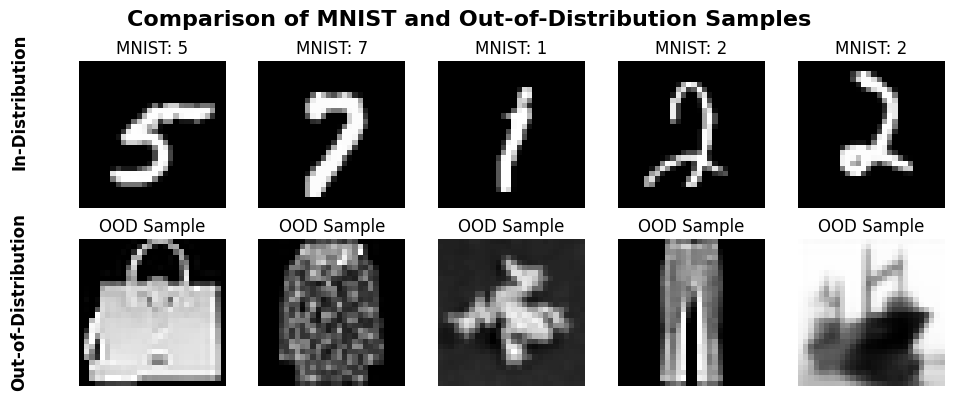

In [10]:
# Enable CUDA optimizations
torch.backends.cudnn.benchmark = True

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Data preparation
train_loader, val_loader, test_loader, test_set = prepare_data_loaders()
fashion_loader, cifar_loader, combined_ood_loader, fashion_subset, cifar_subset, combined_ood = prepare_outlier_data()

# Visualize some data examples
print("Some exampels of the Data:")
visualize_data_examples(test_set, combined_ood)

# Create combined test set with MNIST and outliers
test_with_outliers = CombinedDataset(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((transform_params['normalization_mean'],), (transform_params['normalization_std'],))
    ])),
    combined_ood
)
test_with_outliers_loader = DataLoader(test_with_outliers, batch_size=batch_size, shuffle=False, num_workers=2)


Initialize model

Running in testing mode.
Computed class means and set threshold to 2.49
Distance statistics: min=0.22, mean=1.27, max=5.99


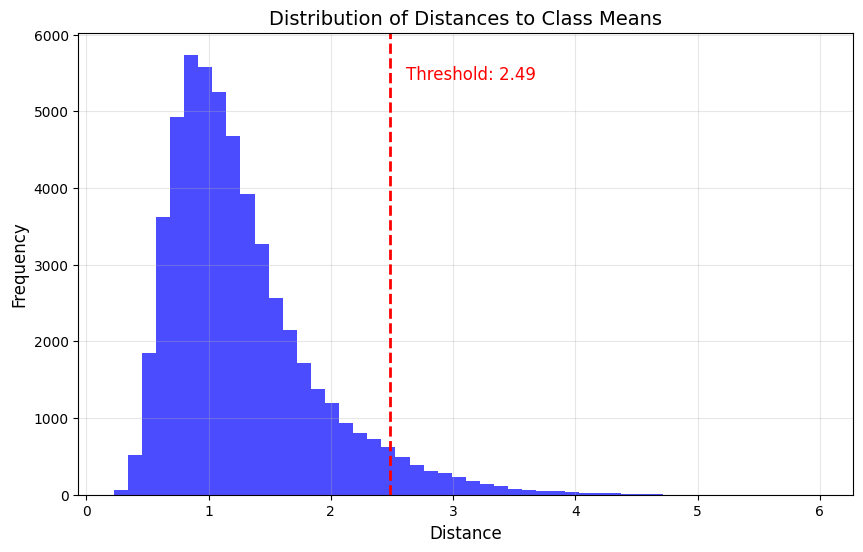

In [11]:
model = TwoStageOpenMax(embedding_dim=embed_size).to(device)

if eval_mode:
    print("Running in testing mode.")
    try:
        retrieve_model(model, osr_model_path)
        model.compute_class_means(train_loader, percentile=rejection_percentile)
    except Exception as e:
        print(f"Error loading model: {str(e)}")
else:
    print("Running full pipeline with training")
    # Training
    processor = ModelProcessor(model, train_loader, val_loader)
    best_val_acc = processor.train(num_epochs=num_epochs)
    print(f"Training completed with best validation accuracy: {best_val_acc:.2f}%")

Evaluation - MNIST 


Evaluating model on MNIST test set.

Detailed Results:
--------------------------------------------------

MNIST Results:
Accuracy: 94.37%
Average Confidence: 98.77%
Average Distance: 1.28


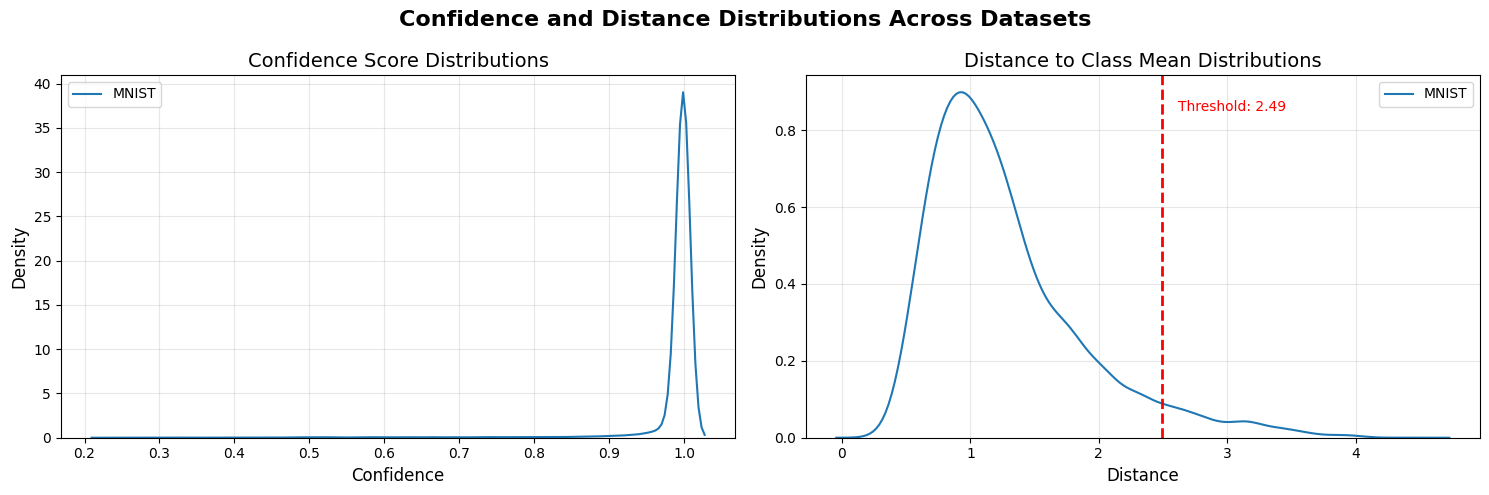

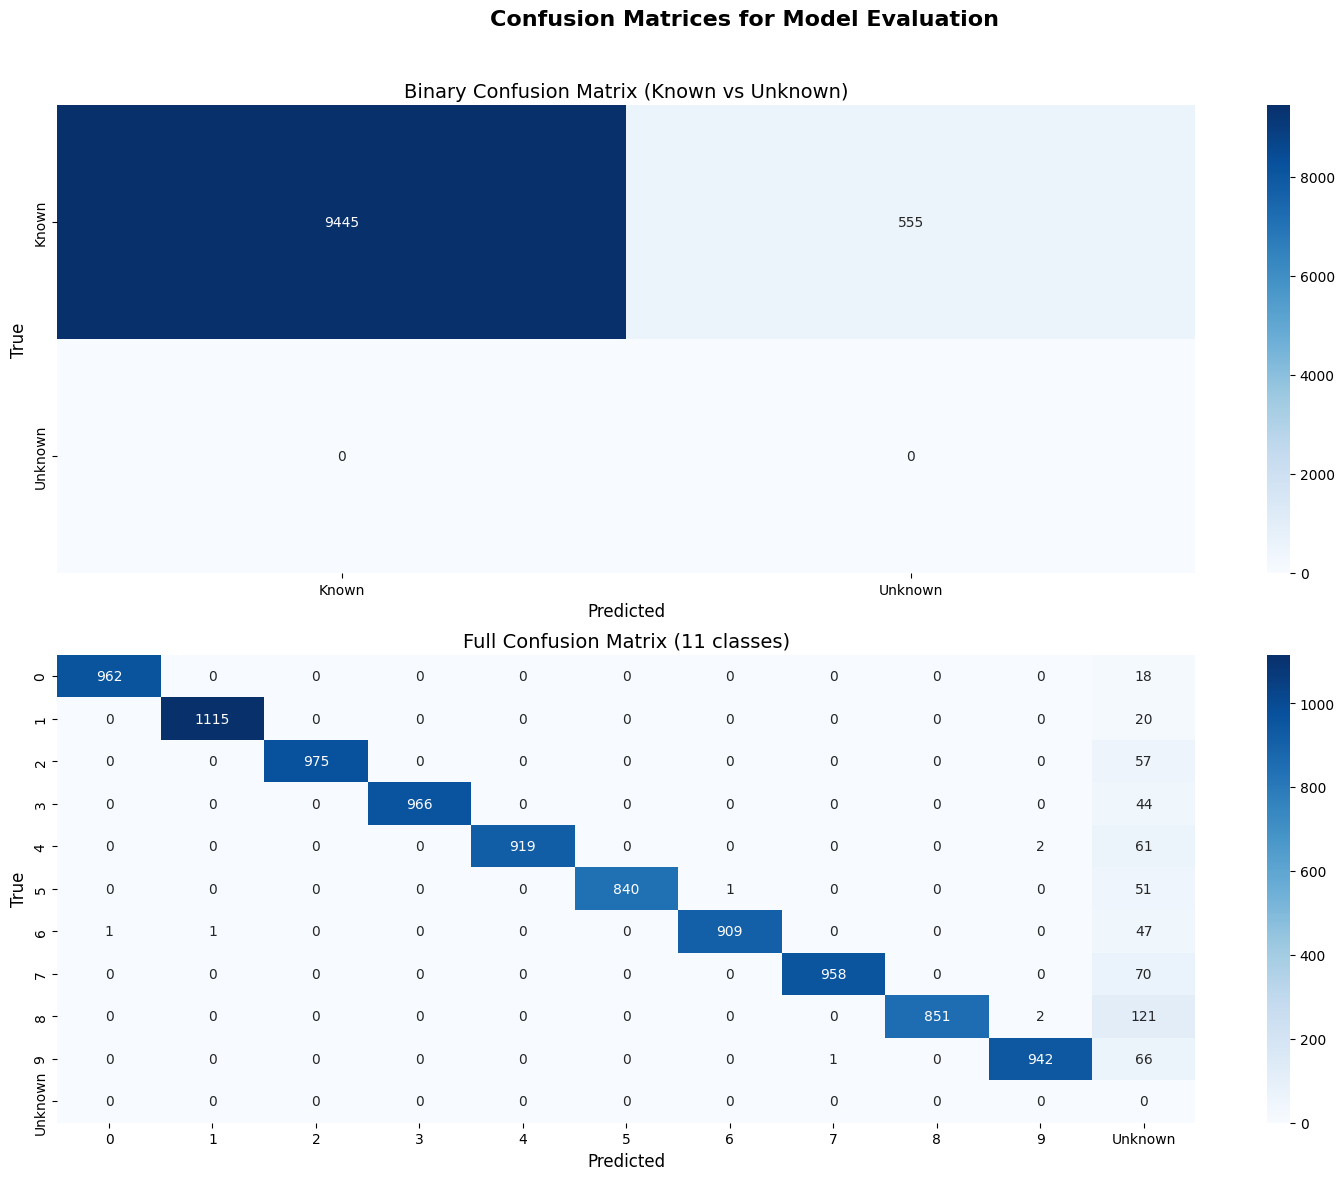

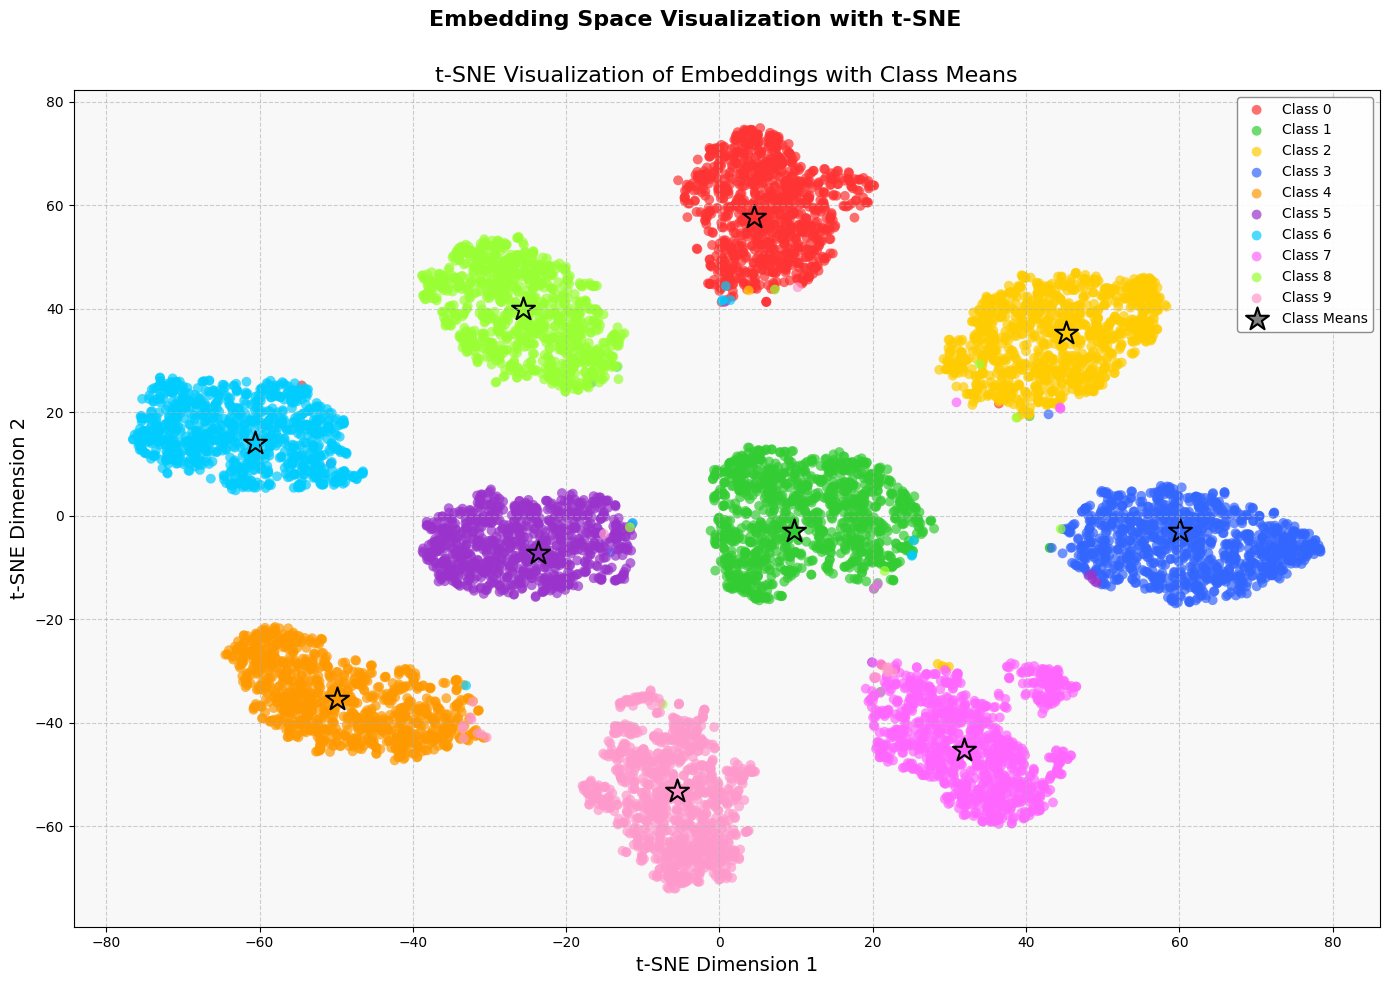

In [ ]:
# Evaluate standard classification performance on MNIST only
print("\nEvaluating model on MNIST test set.")
mnist_results = evaluate_model_performance(model, test_loader, [], ['MNIST'])

Evaluation - MNIST & CIFAR10/Fashion-MNIST


Evaluating model on MNIST + outliers.

Results from eval_model style evaluation:
MNIST Accuracy: 94.37%
OOD Accuracy: 98.75%
Total Accuracy: 95.10%

Detailed Results:
--------------------------------------------------

MNIST Results:
Accuracy: 94.37%
Average Confidence: 98.77%
Average Distance: 1.28

Combined OOD Results:
Accuracy: 98.75%
Average Confidence: 43.90%
Average Distance: 3.61


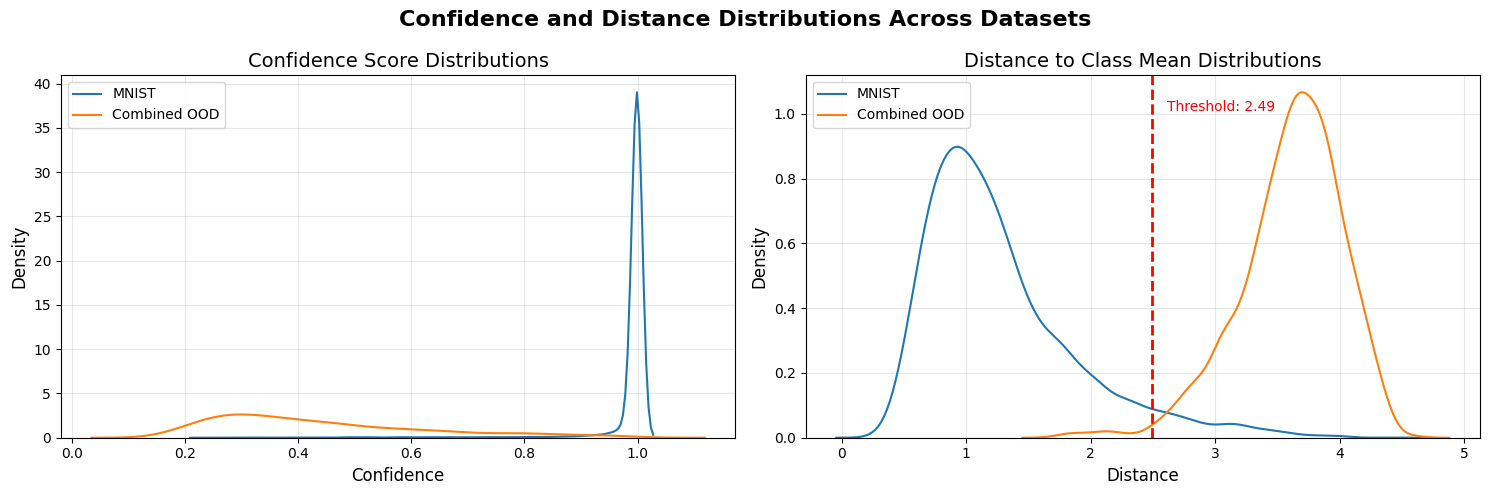

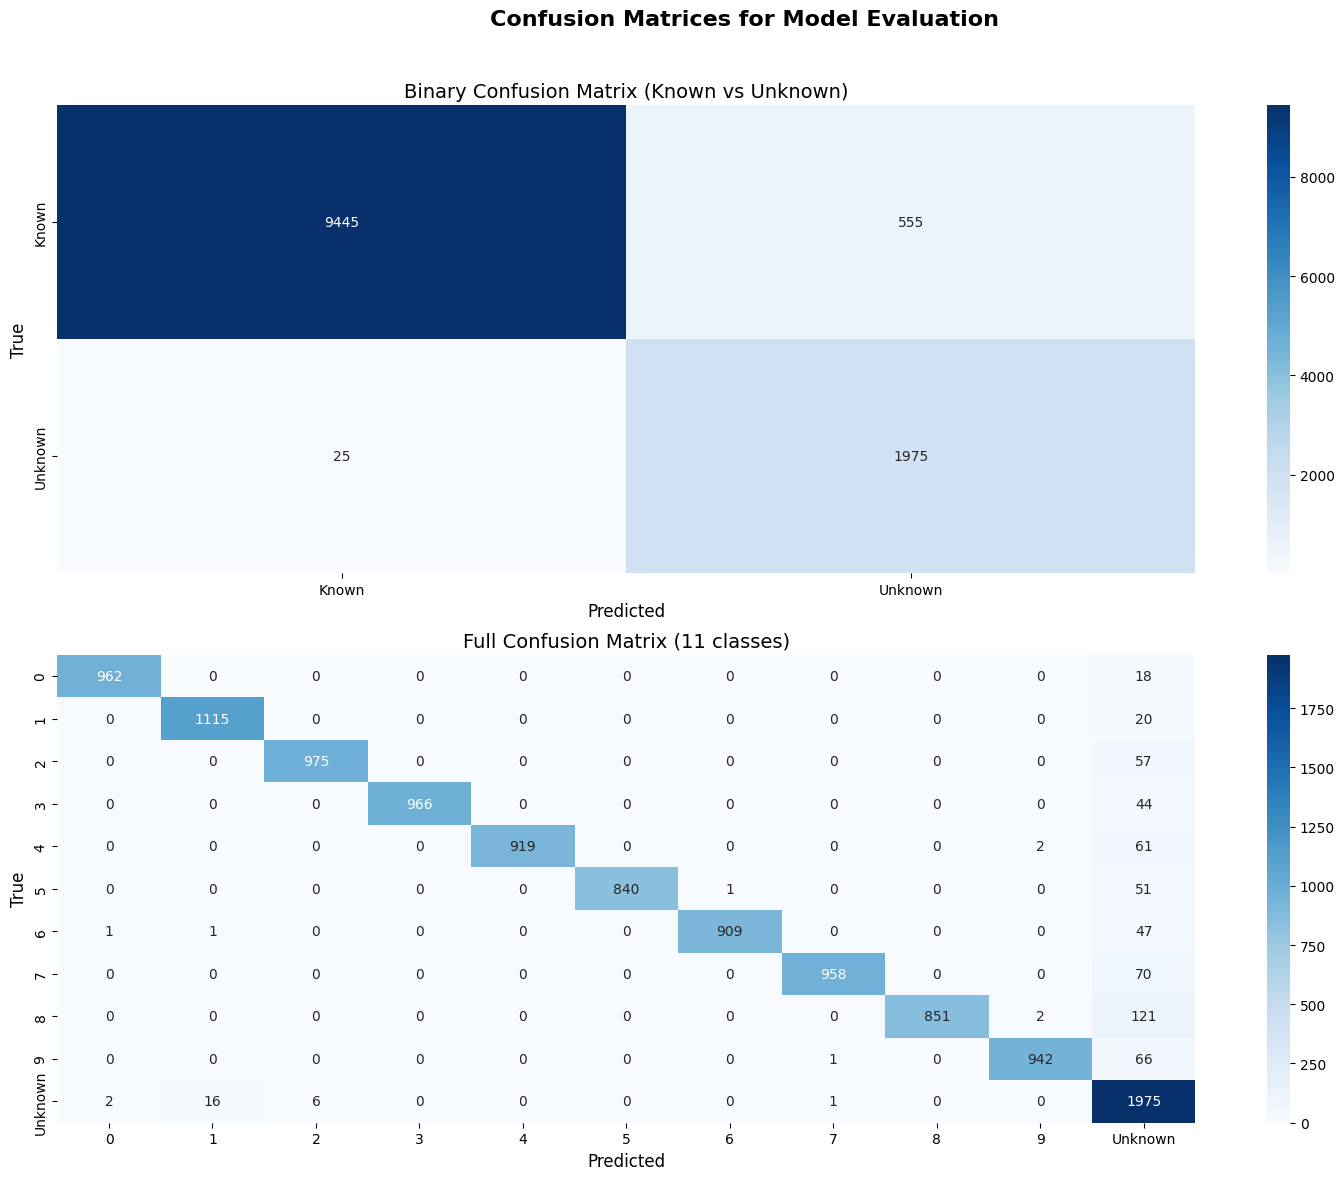

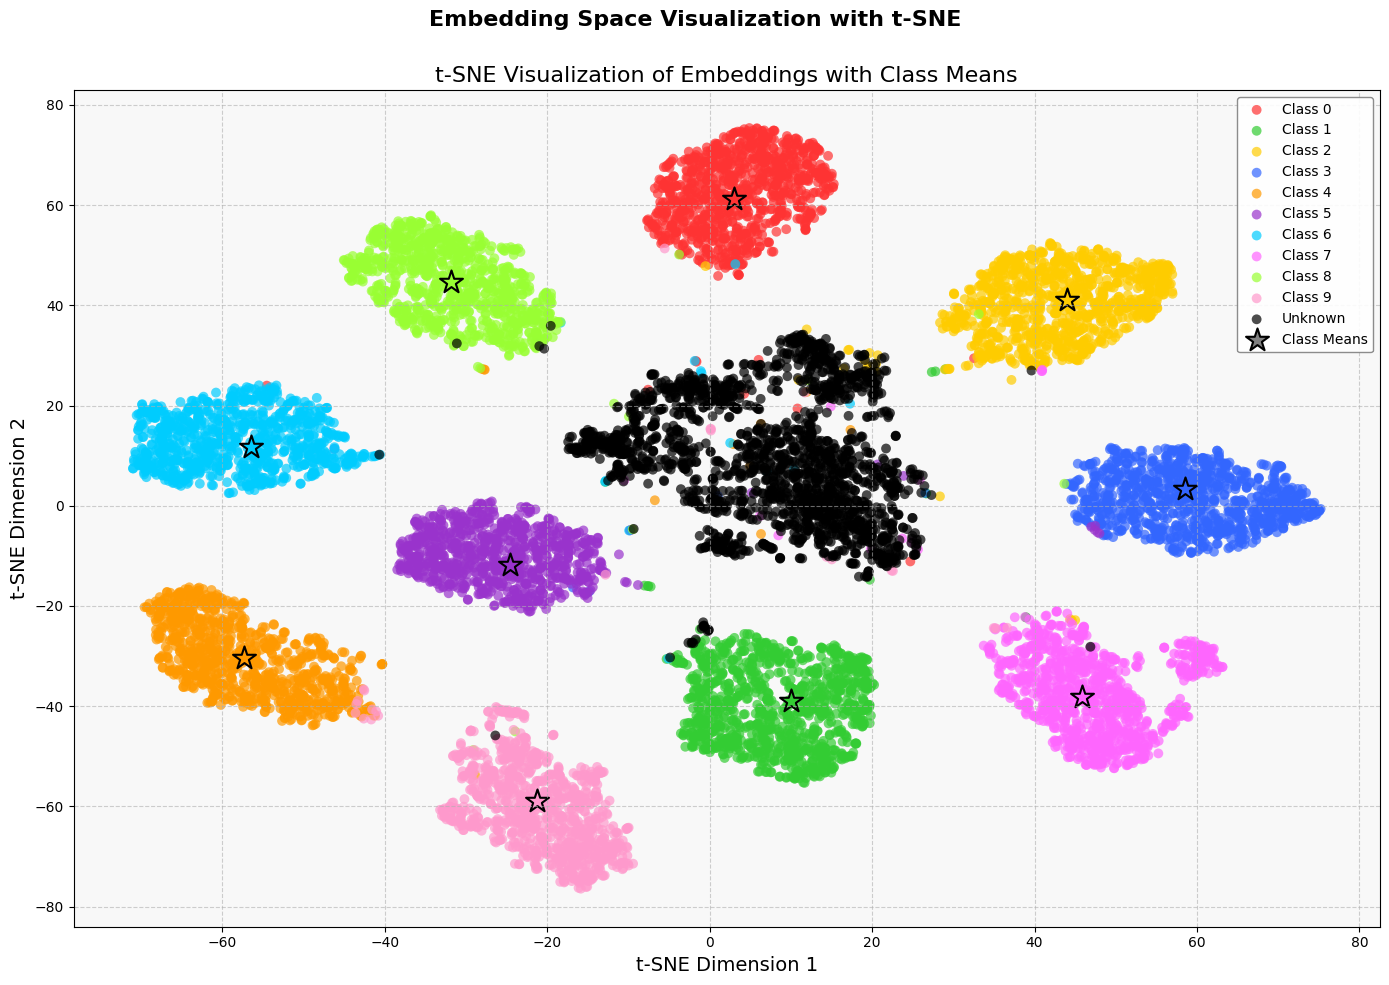

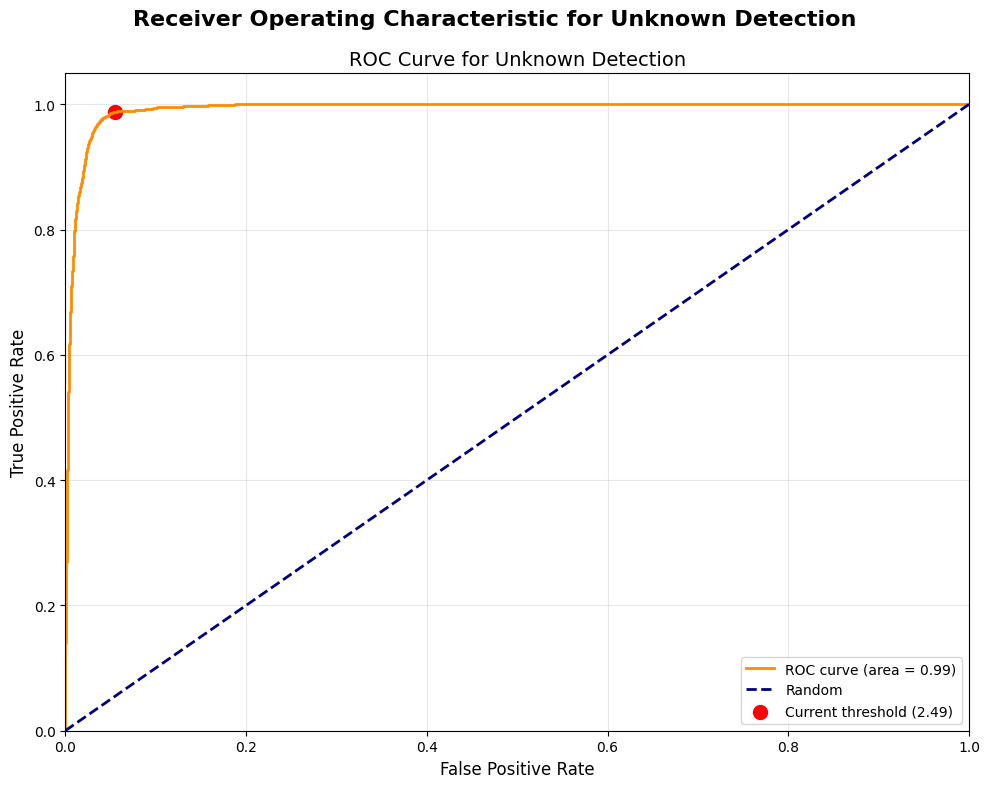

In [ ]:
# Evaluate on MNIST and OOD as FashionMNIST and CIFAR10
print("\nEvaluating model on MNIST + outliers.")
full_results = evaluate_model_performance(
    model,
    test_loader,
    [fashion_loader, cifar_loader, combined_ood_loader],
    ['MNIST', 'FashionMNIST', 'CIFAR10', 'Combined OOD']
)

Visualize model predictions

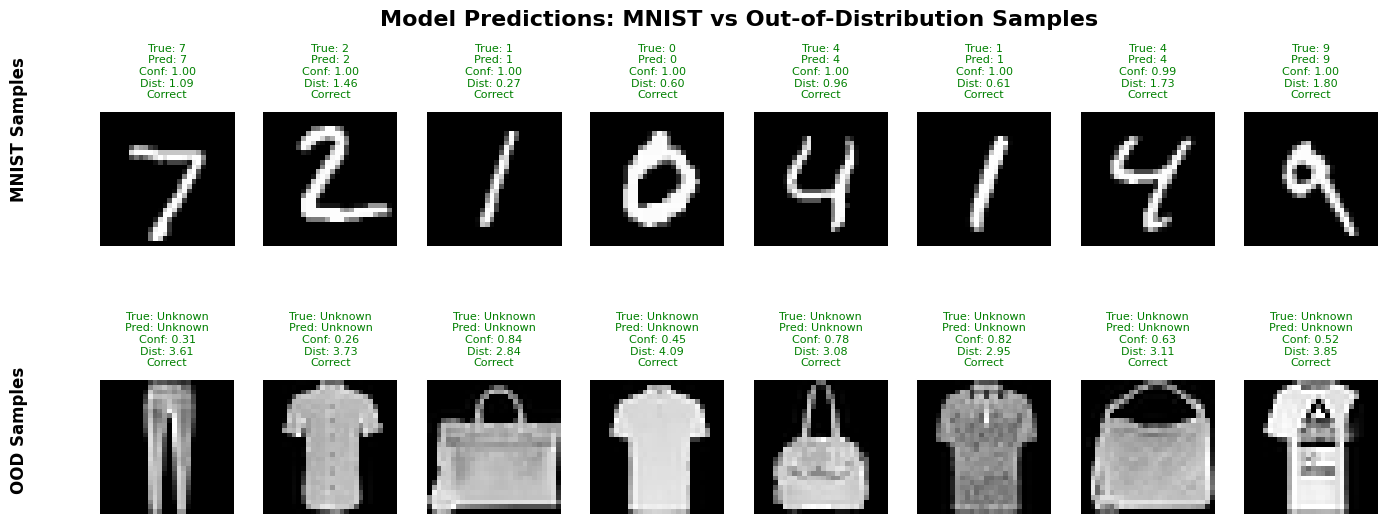

In [14]:
# Visualize model predictions in a combined view
visualize_model_predictions(model, test_loader, combined_ood_loader)

Binary classification evaluation


Binary classification evaluation (Known vs Unknown):
Binary classification accuracy: 95.17%


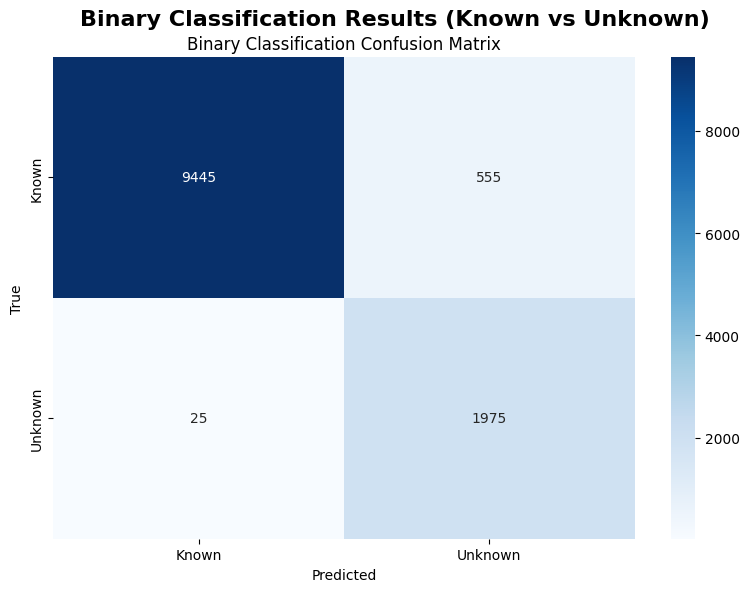

In [15]:
# Binary classification evaluation
print("\nBinary classification evaluation (Known vs Unknown):")
binary_acc = evaluate_binary_classification(model, test_with_outliers_loader, device)

## 5.6 Evaluation - Unknown Dataset

### NOTE TO **GRADER:**
- The function `create_unknown_dataset_placeholder()` creates a placeholder for your unknown dataset.
- To test OSR performance, please replace the empty 'osr_dataset' variable in this function with your evaluation dataset containing unknown classes.

### Example of adding KMNIST, EMNIST, and SVHN as Unknown Classes:

```python
    # Define the transform to match MNIST preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Load additional datasets
    kmnist_dataset = datasets.KMNIST('./data', train=False, download=True, transform=transform)
    emnist_dataset = datasets.EMNIST('./data', split='letters', train=False, download=True, transform=transform)
    svhn_dataset = datasets.SVHN('./data', split='test', download=True, transform=transform)
    
    # Create subsets with 1000 samples each
    kmnist_indices = torch.randperm(len(kmnist_dataset))[:1000]
    emnist_indices = torch.randperm(len(emnist_dataset))[:1000]
    svhn_indices = torch.randperm(len(svhn_dataset))[:1000]
    
    kmnist_subset = Subset(kmnist_dataset, kmnist_indices)
    emnist_subset = Subset(emnist_dataset, emnist_indices)
    svhn_subset = Subset(svhn_dataset, svhn_indices)
    
    # Combine all OOD datasets
    combined_ood_Example = torch.utils.data.ConcatDataset([kmnist_subset, emnist_subset, svhn_subset])
```
Then, in create_unknown_dataset_placeholder() func you need to change the placeholder s.t:

```python

def create_unknown_dataset_placeholder():
    ...
    osr_dataset = combined_ood_Example  # This placeholder need to be replaced
    ...

```

In [ ]:
def create_unknown_dataset_placeholder():
    """
    Create a placeholder for the unknown dataset to be used by the grader.

    This combines the MNIST test set with an empty dataset named 'osr dataset'.

    Returns:
        Dataset: Combined dataset with MNIST test data and placeholder for unknown data
    """

    # The correct way to implement this is:
    osr_dataset = None  # This placeholder need to be replaced

    # Get the MNIST test set
    mnist_test = datasets.MNIST('./data', train=False, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((transform_params['normalization_mean'],), (transform_params['normalization_std'],))
                           ]))

    # Combine MNIST test with the empty 'osr dataset'
    combined_dataset = CombinedDataset(mnist_test, osr_dataset)

    return combined_dataset

### Model Evaluation Results

The following code block executes our comprehensive model evaluation pipeline on your unknown data and will generate these outputs:

1. **Visual Sample Comparison**:
   - Side-by-side display of MNIST vs OOD images
   - Each image labeled with true class, predicted class, confidence score, distance, and correctness 
   - Green/red color coding for correct/incorrect predictions

2. **Visualization Suite**:
   - **Confusion matrices**: Both binary (Known vs Unknown) and full 11-class matrices
   - **t-SNE visualization**: Embedding space with color-coded classes and class means

3. **Performance Summary**:
   - MNIST classification accuracy
   - OOD detection rate
   - Overall accuracy across both datasets
   - Distance threshold and rejection percentile values
   - Binary classification metrics (TP, FP, TN, FN)

In [ ]:
if eval_mode:
    # Create placeholder for unknown dataset evaluation
    unknown_test_placeholder = create_unknown_dataset_placeholder()
    unknown_test_loader = DataLoader(unknown_test_placeholder, batch_size=batch_size, shuffle=False, num_workers=2)

    # Compare individual samples
    print("\nComparing individual samples from test and unknown datasets:")
    # Obtain loader for OOD part of the unknown dataset
    if unknown_test_placeholder.ood is not None:
        ood_dataset = unknown_test_placeholder.ood
        ood_loader = DataLoader(ood_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
        visualize_model_predictions(model, test_loader, ood_loader)
    else:
        print("No OOD samples available for comparison.")

    # Full evaluation on the unknown dataset
    unknown_results = evaluate_model_performance(model, unknown_test_loader, [], ['MNIST'])

    # Summary output
    print("MODEL PERFORMANCE SUMMARY:")
    print("Key Results:")
    print("-----------")

    # Use eval_model metrics if available
    if 'eval_model' in unknown_results:
        combined_results = unknown_results['eval_model']

        mnist_acc = 100 * combined_results.get('correct_mnist', 0) / combined_results.get('total_mnist', 1)
        ood_acc = 100 * combined_results.get('correct_ood', 0) / combined_results.get('total_ood', 1)
        overall_acc = 100 * (combined_results.get('correct_mnist', 0) + combined_results.get('correct_ood', 0)) / (combined_results.get('total_mnist', 1) + combined_results.get('total_ood', 1))

        print(f"MNIST Accuracy: {mnist_acc:.2f}%")
        print(f"OOD Detection Rate: {ood_acc:.2f}%")
        print(f"Overall Accuracy: {overall_acc:.2f}%")
    else:
        # Fallback calculation
        print("No eval_model metrics available")


    # Get threshold
    try:
        threshold = model.distance_threshold.cpu().numpy()
    except:
        threshold = 0

    print(f"Distance Threshold: {threshold:.2f}")
    print(f"Rejection Percentile: {rejection_percentile}")

    # Binary classification metrics
    if 'eval_model' in unknown_results:
      combined_results = unknown_results['eval_model']

      total_samples = combined_results.get('total_mnist', 0) + combined_results.get('total_ood', 0)
      total_correct = combined_results.get('correct_mnist', 0) + combined_results.get('correct_ood', 0)

      binary_accuracy = 100 * total_correct / total_samples if total_samples > 0 else 0

      print()
      print("Binary Classification Metrics (Known vs Unknown)")
      print("-----------------------------------------------")
      print(f"True Positives: {combined_results.get('correct_ood', 0)}")
      print(f"False Positives: {combined_results.get('total_mnist', 0) - combined_results.get('correct_mnist', 0)}")
      print(f"True Negatives: {combined_results.get('correct_mnist', 0)}")
      print(f"False Negatives: {combined_results.get('total_ood', 0) - combined_results.get('correct_ood', 0)}")
      print(f"Binary Classification Accuracy: {binary_accuracy:.2f}%")
    else:
      print("No binary classification metrics available.")

# Appendix: Hyperparameter Optimization Code

The following code was used to run our ablation studies analyzing the impact of embedding dimension and rejection threshold on model performance. This code is provided for reference only and is not part of the main assignment.

```python
def run_embedding_dimension_study(device, train_loader, val_loader, test_loader, combined_ood_loader):
   print("Running embedding dimension study...")

   # Test different embedding dimensions
   embed_dims = [32, 64, 128]
   results = []

   for dim in embed_dims:
       result = create_and_train_model_with_dim(
           dim, train_loader, val_loader, test_loader, combined_ood_loader, device
       )
       results.append(result)

   # Extract results
   mnist_acc_by_dim = [r["mnist_acc"] for r in results]
   ood_acc_by_dim = [r["ood_acc"] for r in results]

   # Plot results
   plt.figure(figsize=(10, 6))
   plt.plot(embed_dims, mnist_acc_by_dim, marker='o', label='MNIST Accuracy', color='blue')
   plt.plot(embed_dims, ood_acc_by_dim, marker='s', label='OOD Detection Accuracy', color='red')
   plt.xlabel('Embedding Dimension', fontsize=12)
   plt.ylabel('Accuracy (%)', fontsize=12)
   plt.title('Impact of Embedding Dimension on Model Performance', fontsize=14)
   plt.xticks(embed_dims)
   plt.grid(True, alpha=0.3)
   plt.legend(fontsize=12)
   plt.tight_layout()
   plt.savefig('output_embedding_dim.png', dpi=300)
   plt.show()

   # Compute total accuracy
   total_acc_by_dim = []
   for i in range(len(embed_dims)):
       mnist_size = len(test_loader.dataset)
       ood_size = len(combined_ood_loader.dataset)
       total_size = mnist_size + ood_size
       total_acc = (mnist_acc_by_dim[i] * mnist_size + ood_acc_by_dim[i] * ood_size) / total_size
       total_acc_by_dim.append(total_acc)

   # Plot total accuracy
   plt.figure(figsize=(10, 6))
   plt.plot(embed_dims, total_acc_by_dim, marker='o', label='Overall Accuracy', color='purple')
   plt.axvline(x=64, color='green', linestyle='--', label='Selected Dimension (64)')
   plt.xlabel('Embedding Dimension', fontsize=12)
   plt.ylabel('Overall Accuracy (%)', fontsize=12)
   plt.title('Impact of Embedding Dimension on Overall Performance', fontsize=14)
   plt.xticks(embed_dims)
   plt.grid(True, alpha=0.3)
   plt.legend(fontsize=12)
   plt.tight_layout()
   plt.savefig('output_embedding_dim_total.png', dpi=300)
   plt.show()

   # Generate LaTeX table for paper
   print("\nLaTeX table for embedding dimensions:")
   print("\\begin{table}[h]")
   print("\\centering")
   print("\\begin{tabular}{cccc}")
   print("\\toprule")
   print("\\textbf{Embedding Dim} & \\textbf{MNIST Acc.} & \\textbf{OOD Acc.} & \\textbf{Overall Acc.} \\\\")
   print("\\midrule")
   for i, dim in enumerate(embed_dims):
       print(f"{dim} & {mnist_acc_by_dim[i]:.2f}\\% & {ood_acc_by_dim[i]:.2f}\\% & {total_acc_by_dim[i]:.2f}\\% \\\\")
   print("\\bottomrule")
   print("\\end{tabular}")
   print("\\caption{Impact of embedding dimension on model performance.}")
   print("\\label{tab:embedding_dim}")
   print("\\end{table}")

   return {
       "embed_dims": embed_dims,
       "mnist_acc_by_dim": mnist_acc_by_dim,
       "ood_acc_by_dim": ood_acc_by_dim,
       "total_acc_by_dim": total_acc_by_dim,
       "results": results
   }

# Function signature and brief description of create_and_train_model_with_dim
# The full implementation is omitted due to length (over 150 lines)
def create_and_train_model_with_dim(embed_dim, train_loader, val_loader, test_loader, combined_ood_loader, device):
   """
   Creates and trains a TwoStageOpenMax model with the specified embedding dimension.
   
   This function:
   1. Creates a new model with the specified embedding dimension
   2. Trains the model for 50 epochs using Adam optimizer
   3. Computes class means and sets the rejection threshold at 95th percentile
   4. Evaluates performance on MNIST test set and OOD datasets
   5. Returns performance metrics
   
   Returns:
       dict: Contains embedding dimension and performance metrics
   """
   # Full implementation omitted for brevity (over 150 lines of code)
   pass

def run_threshold_analysis(device, model, train_loader, test_loader, combined_ood_loader):
   print("Running threshold sensitivity analysis...")
   
   # Effect of Rejection Threshold - limited to just 4 key values
   model.eval()
   percentiles = [85, 90, 95, 99]  
   mnist_acc_by_thresh = []
   ood_acc_by_thresh = []
   threshold_values = []
   
   # Save original threshold
   original_threshold = model.distance_threshold.clone()
   
   # Get all distances from training data
   all_distances = []
   with torch.no_grad():
       for data, targets in tqdm(train_loader, desc="Computing distances for all samples"):
           data, targets = data.to(device), targets.to(device)
           _, embeddings = model(data)
           
           for i, target in enumerate(targets):
               class_mean = model.class_means[target]
               distance = torch.norm(embeddings[i] - class_mean).item()
               all_distances.append(distance)
   
   all_distances = np.array(all_distances)
   
   for percentile in tqdm(percentiles, desc="Testing different thresholds"):
       # Set threshold to specified percentile
       threshold = np.percentile(all_distances, percentile)
       threshold_values.append(threshold)
       model.distance_threshold = torch.tensor(threshold).to(device)
       
       # Evaluate on MNIST
       mnist_acc = 0
       total = 0
       correct = 0
       
       with torch.no_grad():
           for data, targets in tqdm(test_loader, desc=f"Evaluating MNIST (thresh={percentile}%)"):
               data, targets = data.to(device), targets.to(device)
               predictions, _, _ = model.predict_with_detection(data)
               
               # Count correct predictions for MNIST
               correct += (predictions == targets).sum().item()
               total += len(data)
       
       mnist_acc = correct / total * 100
       mnist_acc_by_thresh.append(mnist_acc)
       
       # Evaluate on OOD
       ood_acc = 0
       total = 0
       correct = 0
       
       with torch.no_grad():
           for data, _ in tqdm(combined_ood_loader, desc=f"Evaluating OOD (thresh={percentile}%)"):
               data = data.to(device)
               predictions, _, _ = model.predict_with_detection(data)
               
               # Count correct predictions for OOD (unknown)
               correct += (predictions == 10).sum().item()
               total += len(data)
       
       ood_acc = correct / total * 100
       ood_acc_by_thresh.append(ood_acc)
   
   # Plot threshold results
   plt.figure(figsize=(10, 6))
   plt.plot(percentiles, mnist_acc_by_thresh, marker='o', label='MNIST Accuracy', color='blue')
   plt.plot(percentiles, ood_acc_by_thresh, marker='s', label='OOD Detection Accuracy', color='red')
   plt.xlabel('Rejection Threshold Percentile', fontsize=12)
   plt.ylabel('Accuracy (%)', fontsize=12)
   plt.title('Impact of Rejection Threshold on Model Performance', fontsize=14)
   plt.xticks(percentiles)
   plt.grid(True, alpha=0.3)
   plt.legend(fontsize=12)
   plt.tight_layout()
   plt.savefig('output_threshold.png', dpi=300)
   plt.show()
   
   # Compute total accuracy
   total_acc_by_thresh = []
   for i in range(len(percentiles)):
       # Weighted average based on dataset sizes
       mnist_size = len(test_loader.dataset)
       ood_size = len(combined_ood_loader.dataset)
       total_size = mnist_size + ood_size
       total_acc = (mnist_acc_by_thresh[i] * mnist_size + ood_acc_by_thresh[i] * ood_size) / total_size
       total_acc_by_thresh.append(total_acc)
   
   # Generate LaTeX table for paper
   print("\nLaTeX table for threshold sensitivity:")
   print("\\begin{table}[h]")
   print("\\centering")
   print("\\begin{tabular}{ccccc}")
   print("\\toprule")
   print("\\textbf{Percentile} & \\textbf{Threshold Value} & \\textbf{MNIST Acc.} & \\textbf{OOD Acc.} & \\textbf{Overall Acc.} \\\\")
   print("\\midrule")
   for i, perc in enumerate(percentiles):
       print(f"{perc}\\% & {threshold_values[i]:.2f} & {mnist_acc_by_thresh[i]:.2f}\\% & {ood_acc_by_thresh[i]:.2f}\\% & {total_acc_by_thresh[i]:.2f}\\% \\\\")
   print("\\bottomrule")
   print("\\end{tabular}")
   print("\\caption{Impact of different rejection threshold percentiles on model performance.}")
   print("\\label{tab:threshold_sensitivity}")
   print("\\end{table}")
   
   # Restore original threshold
   model.distance_threshold = original_threshold
   
   return {
       "percentiles": percentiles,
       "threshold_values": threshold_values,
       "mnist_acc_by_thresh": mnist_acc_by_thresh,
       "ood_acc_by_thresh": ood_acc_by_thresh,
       "total_acc_by_thresh": total_acc_by_thresh
   }